# Mapping Comparison via H₃⁺

This notebook compares different fermion-to-qubit mappings applied to the H₃⁺ molecule.
Each mapping is evaluated under the same ansatz (UCCSD) and optimizer (Adam).

We analyze:
- Qubit Hamiltonian complexity (Pauli term count),
- Energy convergence over 50 VQE iterations,
- Final ground state energy from each mapping.

Mappings compared:
- Jordan-Wigner (JW)
- Bravyi-Kitaev (BK)
- Parity

In [ ]:
import pennylane as qml            # Quantum circuit builder and device management
from pennylane import numpy as np  # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem        # Quantum chemistry module used to define molecule Hamiltonians
import matplotlib.pyplot as plt
import sys, os, json, time
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.vqe_utils import excitation_ansatz, get_optimizer, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs, build_run_filename
from src.vqe_utils import RESULTS_DIR, IMG_DIR

seed = 0
set_seed(seed)  # Reproducible runs
ensure_dirs()   # Creates results/ and images/, if missing

In [2]:
# Geometry of Trihydrogen Cation (Å; slight distortion to break symmetry)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [ 0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000,  0.000000],
    [ 0.800000, -0.300000,  0.000000],
])

electrons = 2
basis = "STO-3G"
mappings = ["jordan_wigner", "bravyi_kitaev", "parity"]
hamiltonians, qubits_required, pauli_terms = {}, {}, {}

# Build qubit Hamiltonians per mapping (and record complexity)
for mapping in mappings:
    H, qubits = qchem.molecular_hamiltonian(
        symbols, coordinates, charge=+1, basis=basis, mapping=mapping, active_electrons=electrons
    )
    hamiltonians[mapping] = H
    qubits_required[mapping] = qubits
    pauli_terms[mapping] = len(H)
    print(f"{mapping:>15}: {len(H)} Pauli terms with {qubits} qubits")

  jordan_wigner: 118 Pauli terms with 6 qubits
  bravyi_kitaev: 118 Pauli terms with 6 qubits
         parity: 118 Pauli terms with 6 qubits


[saved] jordan_wigner: runs/H3+_Mapping_jordan_wigner_Adam_s0__11643ff8e207.json
[mirrored] results/H3+_Mapping_jordan_wigner_Adam_s0__11643ff8e207.json
[saved] bravyi_kitaev: runs/H3+_Mapping_bravyi_kitaev_Adam_s0__120de68b9ffe.json
[mirrored] results/H3+_Mapping_bravyi_kitaev_Adam_s0__120de68b9ffe.json
[saved] parity: runs/H3+_Mapping_parity_Adam_s0__c37a6be95c44.json
[mirrored] results/H3+_Mapping_parity_Adam_s0__c37a6be95c44.json


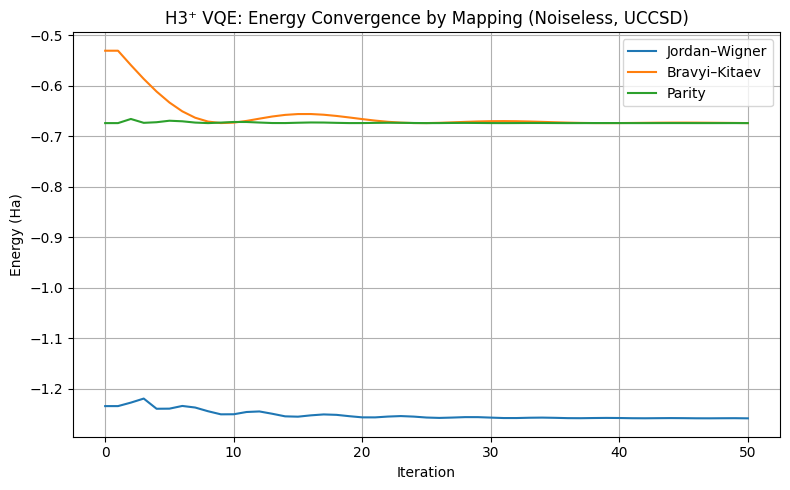

In [ ]:
# Use Jordan-Wigner qubit count as baseline for excitations (identical across mappings here)
qubits = qubits_required["jordan_wigner"]
hf_state = qchem.hf_state(electrons, qubits)
singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]

def run_mapping_with_cache(mapping, stepsize=0.2, max_iter=50):
    """Run (or load) VQE for a given fermion-to-qubit mapping using UCCSD + Adam."""
    H = hamiltonians[mapping]
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def cost_fn(params):
        excitation_ansatz(
            params,
            wires=range(qubits),
            hf_state=hf_state,
            excitations=(singles, doubles),
            excitation_type="both",
        )
        return qml.expval(H)

    # Config/signature (encode mapping inside the ansatz description so the hash is unique)
    ansatz_desc = f"UCC singles+doubles (mapping={mapping})"
    optimizer_name = "Adam"

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=seed,
    )

    # Human-readable filename + signature (mapping included)
    sig = run_signature(cfg)
    fname = build_run_filename(f"H3+_Mapping_{mapping}", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {mapping}: loaded {existing}")
        energies = rec["energies"]
        return energies

    # Compute results if this configuration has NOT been ran before
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    energies = [float(cost_fn(params))]
    for _ in range(max_iter):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(float(e_prev))
    energies[-1] = float(cost_fn(params))

    run_record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3+",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": qubits,
        "mapping": mapping,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iter,
            "iterations_ran": len(energies) - 1,
        },
        "seed": seed,
        "energies": energies,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
        "metadata": {"pauli_terms": pauli_terms[mapping]},
    }

    persisted = save_run_record(fname, run_record)
    print(f"[saved] {mapping}: {fname}")
    print(f"[mirrored] {persisted}")
    return energies

# Run (or load) all mappings
results = {}
for m in mappings:
    results[m] = run_mapping_with_cache(mapping=m, stepsize=0.2, max_iter=50)

# Plot energy convergence
label_map = {"jordan_wigner": "Jordan–Wigner", "bravyi_kitaev": "Bravyi–Kitaev", "parity": "Parity"}
plt.figure(figsize=(8, 5))
for m in mappings:
    plt.plot(results[m], label=label_map.get(m, m))
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H3⁺ VQE: Energy Convergence by Mapping (Noiseless, UCCSD)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{IMG_DIR}/H3plus_Mapping_Comparison.png", dpi=300)
plt.show()

In [4]:
# Print final energies
print("\nFinal VQE Energies:")
for m in mappings:
    print(f"{m:>15}: {results[m][-1]:.8f} Ha")


Final VQE Energies:
  jordan_wigner: -1.25867803 Ha
  bravyi_kitaev: -0.67410221 Ha
         parity: -0.67413491 Ha
